Exercise 1: Data preprocessing

In [1]:
#Load the data using pandas
#Import all the required packages
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt

#Reading the content from the HTML page using requests package
url = "http://www.stat.ufl.edu/~winner/data/airq402.dat"
data = requests.get(url).content

#Splitting the data into rows and columns
cleanedData = data.decode('utf-8').split('\n')
rowsAndColumns = [each.split() for each in cleanedData]

#Adding a header to the data
header = ['city1','city2','avgFair','distance','avgPassengers','leadingAirline','marketShare','avgFare','lowPriceAirline','marketShare2','price']

#The final dataframe
df = pd.DataFrame(rowsAndColumns, columns = header)
df = df.loc[0:999,:]

#Converting numeric entries to float  
numeric = ['avgFair','distance','avgPassengers','marketShare','avgFare','marketShare2','price']
for each in numeric:
    df[each] = df[each].astype('float')
print(df.describe())


          avgFair     distance  avgPassengers  marketShare     avgFare  \
count  1000.00000  1000.000000    1000.000000  1000.000000  1000.00000   
mean    163.37542  1056.973000     672.279140    60.128590   166.64756   
std      55.36547   643.203251     766.519254    19.367779    62.66014   
min      50.52000   108.000000     181.410000    17.680000    50.52000   
25%     125.97500   553.500000     257.197500    46.510000   124.08500   
50%     161.34500   919.000000     404.780000    59.240000   161.40000   
75%     197.39250  1452.500000     769.912500    73.510000   202.97750   
max     401.23000  2724.000000    8950.760000   100.000000   490.03000   

       marketShare2        price  
count   1000.000000  1000.000000  
mean      34.551480   143.193090  
std       27.096999    47.229184  
min        1.060000    49.610000  
25%       13.195000   113.767500  
50%       26.140000   137.825000  
75%       52.972500   168.530000  
max      100.000000   387.940000  


In [2]:
#1.Non-numeric values to numeric
#Hot-one encoding
dfNew = pd.get_dummies(df,columns = ['city1','city2','leadingAirline','lowPriceAirline'])
print(dfNew.shape)

#The dimension of the matrix changes from 1000*11 to 1000*217, this increases the cost of computation,
#so integer encoding can be used to reduce the cost of operations

#Interger encoding
col = ['city1','city2','leadingAirline','lowPriceAirline']
for each in col:
    df[each] = df[each].astype('category')
    df[each] = df[each].cat.codes
print(df.shape)     

(1000, 217)
(1000, 11)


In [3]:
#2.Check for na 
print("NA's present : ",df.isnull().any().any())
#No null values 

NA's present :  False


In [4]:
#3. Split the data into test and train
#Generate a random list of true and false and assign train and test based on those values
split = np.random.rand(len(df)) < 0.8
#Assign train to true
train = df[split]
#Assign test to false
test = df[~split]

print("Train shape : ",train.shape,"\nTest shape : ",test.shape)
print(train.head())

Train shape :  (786, 11) 
Test shape :  (214, 11)
   city1  city2  avgFair  distance  avgPassengers  leadingAirline  \
0     16      0   114.47     528.0         424.56               6   
2      2      0   214.42     852.0         215.76               4   
3      2      7    69.40     288.0         606.84              14   
4      2     52   158.13     723.0         313.04              12   
5      2     18   135.17    1204.0         199.02              14   

   marketShare  avgFare  lowPriceAirline  marketShare2   price  
0        70.19   111.03                8         70.19  111.03  
2        78.89   223.98                5          2.77  167.12  
3        96.97    68.86               17         96.97   68.86  
4        39.79   161.36               17         15.34  145.42  
5        40.68   137.97                6         17.09  127.69  


Exercise 2: Linear Regression with Gradient Descent

In [5]:
#1. Seperating x and y data
xTrain = train.loc[:,train.columns != 'price']
yTrain = train.loc[:,train.columns == 'price']
xTest = test.loc[:,test.columns != 'price']
yTest = test.loc[:,test.columns == 'price']

In [6]:
#2.Linear Regression Base Model,calculating base model to compare with other models
xTrain = np.column_stack([xTrain,np.ones(len(xTrain))])
xTest = np.column_stack([xTest,np.ones(len(xTest))]) 
    
A = xTrain.T.dot(xTrain)
b = xTrain.T.dot(yTrain)
betaOriginal = np.linalg.solve(A,b)
print("Beta Values : ",betaOriginal)

#Predicting the values for xTest
#xTest = np.column_stack([xTest,np.ones(len(xTest))])
#yPredicted = xTest.dot(beta)
#yPredicted1 = xTest.dot(betaNew)
#print("\n\nPredicted values : ",yPredicted)
#print("\n\nPredicted values : ",yPredicted1)

Beta Values :  [[ -3.89060636e-02]
 [  5.67257229e-02]
 [  1.02553289e+00]
 [  4.13217835e-03]
 [ -1.96554851e-03]
 [  1.11544528e-01]
 [ -3.15823060e-01]
 [ -2.26486177e-01]
 [ -6.93468561e-01]
 [  4.33939298e-01]
 [  1.89089165e+01]]


In [7]:
#3.Least square loss function
def leastSquareLoss(x,y,beta):
    yPredicted = x.dot(beta)
    leastSquareLoss = (np.square(y-yPredicted)).sum()
    return(leastSquareLoss)

In [8]:
#Function for derivative -2x.T(y-yHat)
def derivative(x,y,beta):
    predicted = y - (x.dot(beta))
    return ((-2 * np.dot(x.T,predicted)))
    

In [9]:
# 4.learn-linregGD and minimize-GD algorithm
def gradientDescent(xTrain,yTrain,xTest,yTest,alpha):
    beta = np.zeros((xTrain.shape[1],1))
    print("Initial Beta : \n",beta)
    #Find Beta using minimize GD
    #Initializing list to plot the graphs
    loss = []
    ii = []
    rmse = []
    for i in range(1000):
        #Computing next beta
        betaNext = beta - (alpha*derivative(xTrain,yTrain,beta))
        betaLoss = leastSquareLoss(xTrain,yTrain,beta)
        betaNewLoss = leastSquareLoss(xTrain,yTrain,betaNext)
        lossValue = betaLoss - betaNewLoss
        #RMSE for test data
        eachRmse = leastSquareLoss(xTest,yTest,beta)
        #Appending the list with values for each loop
        loss.append(abs(lossValue))
        ii.append(i+1)
        rmse.append(np.sqrt(eachRmse/xTest.shape[0]))
        if float(lossValue) < 0.1:
            print("\nOptimal Beta found : \n",betaNext)
            print("No.of iterations: ",i+1)
            break
        if(i >= 1000):
            print("Gradient descent does not converge")    
        beta = betaNext  
    print("\nAlpha : ",alpha)
    plt.plot(ii,loss,'o',color = 'green')
    plt.xlabel("No. of iterations")
    plt.ylabel("Loss function")
    plt.title("Iterations vs Loss")
    plt.show()
    plt.plot(ii,rmse,'o',color = 'green')
    plt.xlabel("No. of iterations")
    plt.ylabel("RMSE of Test Set")
    plt.title("Iterations vs RMSE of Test Set")
    plt.show()

In [10]:
def gradientDescent_StepLength(xTrain,yTrain,xTest,yTest,Type):
    beta = np.zeros((xTrain.shape[1],1))
    print("Initial Beta : \n",beta)
    #Find Beta using minimize GD
    #List to plot graph
    loss = []
    ii = []
    rmse = []
    for i in range(1000):
        #Initializing all paramters
        lossValue = 0.0
        alpha1,sigma,flag,alphaPlus,alphaMinus,alpha = 1,0,False,1.1,0.5,0.1
        #If learning rate is determined by Armijo
        if Type == "Armijo":
            while flag == False:
                #Computing condition
                condition = (alpha1*sigma)*((derivative(xTrain,yTrain,beta).T).dot(derivative(xTrain,yTrain,beta)))
                #New value to be passed to loss function
                betaNew = beta - (alpha1 * (derivative(xTrain,yTrain,beta)))
                if float(leastSquareLoss(xTrain,yTrain,beta)-leastSquareLoss(xTrain,yTrain,betaNew)) < condition:
                    #Modifying alpha
                    alpha1 = alpha1/2
                else:
                    #Setting the flag to True to come out of the loop
                    flag = True 
                    alpha = alpha1
        #Learning rate bold driver method            
        elif Type == "Bold driver":
            alpha = alpha*alphaPlus
            while flag == False:
                betaNew = beta + (alpha * (-derivative(xTrain,yTrain,beta)))
                if float(leastSquareLoss(xTrain,yTrain,beta)-leastSquareLoss(xTrain,yTrain,betaNew)) <= 0:
                    alpha = alpha*alphaMinus
                else:
                    #Setting the flag to True to come out of the loop
                    flag = True
        else:
            print("\nInvalid input")
        #Setting flag as false to compute alpha for the next Beta    
        flag = False
        betaNext = beta - (alpha*derivative(xTrain,yTrain,beta))
        betaLoss = leastSquareLoss(xTrain,yTrain,beta)
        betaNewLoss = leastSquareLoss(xTrain,yTrain,betaNext)
        lossValue = betaLoss - betaNewLoss
        eachRmse = leastSquareLoss(xTest,yTest,beta)
        loss.append(abs(lossValue))
        ii.append(i+1)
        rmse.append(np.sqrt(eachRmse/xTest.shape[0]))
        if float(lossValue) < 0.01:
            print("\nOptimal Beta found : \n",betaNext)
            print("No.of iterations: ",i+1)
            break
        if(i >= 1000):
            print("Gradient dscent does not converge")    
        beta = betaNext  
    print("\nAlpha : ",alpha)
    plt.plot(ii,loss,'o',color = 'green')
    plt.xlabel("No. of iterations")
    plt.ylabel("Loss function")
    plt.title("Iterations vs Loss")
    plt.show()
    plt.plot(ii,rmse,color = 'green')
    plt.xlabel("No. of iterations")
    plt.ylabel("RMSE of Test Set")
    plt.title("Iterations vs RMSE of Test Set")
    plt.show()

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Optimal Beta found : 
 [[  8.02624962e+04]
 [  1.13048380e+05]
 [  4.01177743e+05]
 [  2.62171548e+06]
 [  1.39648867e+06]
 [  1.69349434e+04]
 [  1.30795313e+05]
 [  4.11588658e+05]
 [  2.18091536e+04]
 [  7.37593536e+04]
 [  2.24177540e+03]]
No.of iterations:  1

Alpha :  0.01


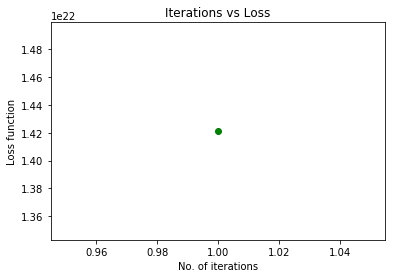

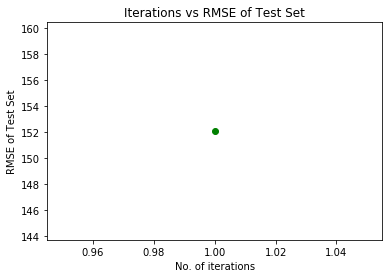

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Alpha :  1e-10


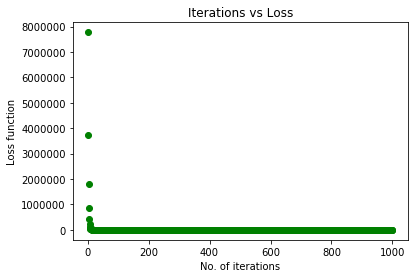

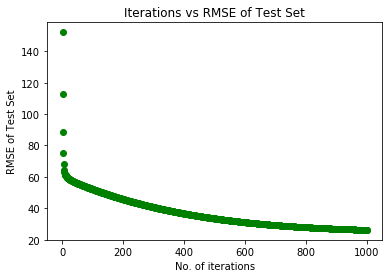

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Alpha :  1e-11


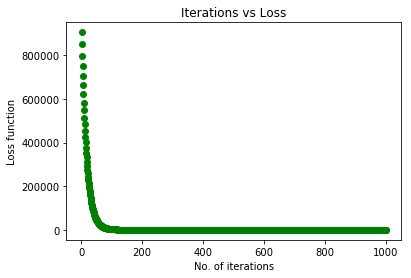

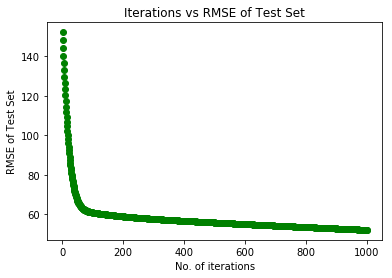

In [11]:
#Original scales in data, using three alphas
alpha = 0.01
gradientDescent(xTrain,yTrain,xTest,yTest,alpha)
#Converges in one iteration since the alpha value is very less, difference in loss function becomes negative 
#which cannot result in minimum beta

alpha = 0.0000000001
gradientDescent(xTrain,yTrain,xTest,yTest,alpha)
#Minimum beta for which the difference in loss function is positive, but does not converge in 1000 iterations
#needs almost 20,000 iterations to converge

alpha = 0.00000000001
gradientDescent(xTrain,yTrain,xTest,yTest,alpha)
#Reducing the beta beyond this futher only reduces the convergence rate

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Alpha :  9.313225746154785e-10


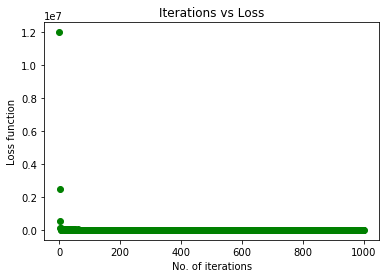

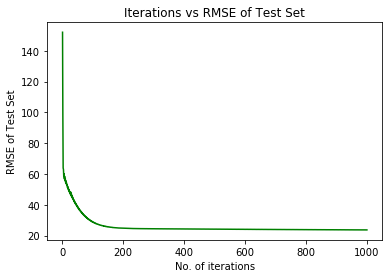

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Alpha :  4.097819328308106e-10


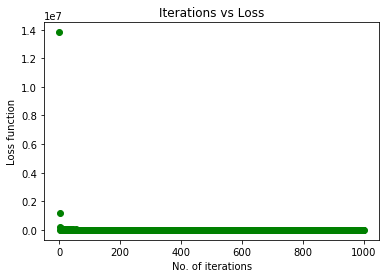

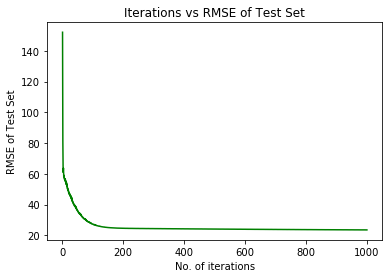

In [12]:
#Calling armijo step length function for original scale
gradientDescent_StepLength(xTrain,yTrain,xTest,yTest,"Armijo")

#Calling armijo step length function for original scale
gradientDescent_StepLength(xTrain,yTrain,xTest,yTest,"Bold driver")

Normalization of data.

In [13]:
#Since, the features have difference in scale, they may take long time to converge, using min-max standardization
#to get convergence
for each in df.columns.values:
    df[each] = (df[each] - df[each].mean())/df[each].std()

#Using the same split, so the data is not resampled
train = df[split]

print("Train shape : ",train.shape,"\nTest shape : ",test.shape)
print(train.head())

#1. Seperating x and y data
xTrain = train.loc[:,train.columns != 'price']
yTrain = train.loc[:,train.columns == 'price']

#Adding bias
xTrain = np.column_stack([xTrain,np.ones(len(xTrain))])

Train shape :  (786, 11) 
Test shape :  (214, 11)
      city1     city2   avgFair  distance  avgPassengers  leadingAirline  \
0 -0.844931 -2.245564 -0.883320 -0.822404      -0.323174       -0.400319   
2 -1.446428 -2.245564  0.921957 -0.318675      -0.595574       -0.773229   
3 -1.446428 -1.932444 -1.697365 -1.195537      -0.085372        1.091322   
4 -1.446428  0.080472 -0.094742 -0.519234      -0.468663        0.718411   
5 -1.446428 -1.440398 -0.509441  0.228586      -0.617413        1.091322   

   marketShare   avgFare  lowPriceAirline  marketShare2     price  
0     0.519492 -0.887607        -0.342771      1.315220 -0.681000  
2     0.968692  0.914975        -0.837390     -1.172878  0.506613  
3     1.902201 -1.560602         1.141086      2.303521 -1.573880  
4    -1.050125 -0.084385         1.141086     -0.708989  0.047151  
5    -1.004172 -0.457668        -0.672517     -0.644406 -0.328252  


Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Optimal Beta found : 
 [[ -0.82900969]
 [  0.39525906]
 [ 13.9202441 ]
 [  9.36242585]
 [ -2.33590989]
 [ -5.36418363]
 [ -4.92207457]
 [ 13.31769873]
 [ -3.60165819]
 [ -3.6772961 ]
 [ -0.19521774]]
No.of iterations:  1

Alpha :  0.01


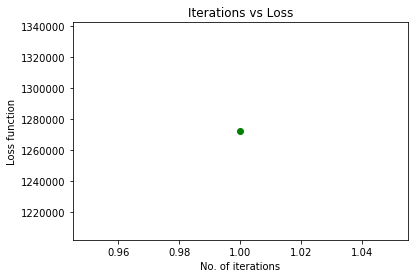

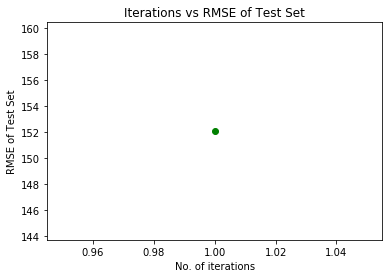

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Optimal Beta found : 
 [[-0.01447083]
 [ 0.01836194]
 [ 0.51554364]
 [ 0.10005037]
 [-0.05387806]
 [-0.01705283]
 [-0.11658869]
 [ 0.35361362]
 [-0.08707852]
 [ 0.25879078]
 [-0.00235392]]
No.of iterations:  41

Alpha :  0.0001


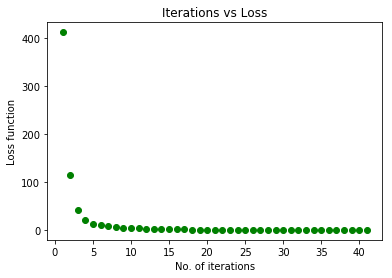

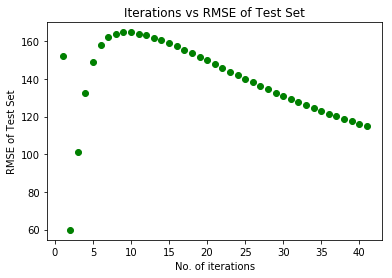

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Optimal Beta found : 
 [[-0.01004913]
 [ 0.01305114]
 [ 0.43441098]
 [ 0.14318193]
 [-0.05886373]
 [-0.04435977]
 [-0.085609  ]
 [ 0.36002962]
 [-0.06870018]
 [ 0.19260407]
 [-0.00176451]]
No.of iterations:  174

Alpha :  1e-05


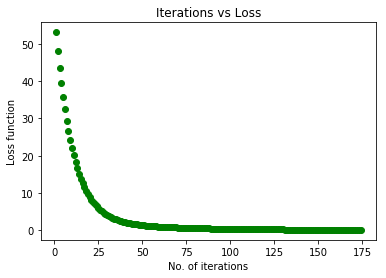

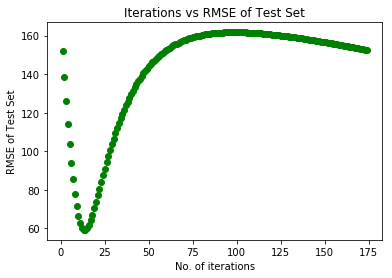

In [14]:
#Normalized scales in data, using three alphas
alpha = 0.01
gradientDescent(xTrain,yTrain,xTest,yTest,alpha)
#Converges in one iteration since the alpha value is very less, difference in loss function becomes negative 
#which cannot result in minimum beta

alpha = 0.0001
gradientDescent(xTrain,yTrain,xTest,yTest,alpha)
#Minimum beta for which the difference in loss function is positive, coverges within 100 iterations 
#due to feature scaling

alpha = 0.00001
gradientDescent(xTrain,yTrain,xTest,yTest,alpha)
#Reducing the beta beyond this futher only reduces the convergence rate

Part B: Step Length for Gradient Descent

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Optimal Beta found : 
 [[-0.01801037]
 [ 0.02473577]
 [ 0.85495222]
 [ 0.07121846]
 [-0.04429127]
 [-0.00185401]
 [-0.13277659]
 [ 0.04782961]
 [-0.09214977]
 [ 0.25532126]
 [-0.00200902]]
No.of iterations:  53

Alpha :  0.0009765625


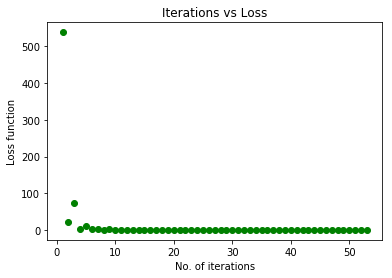

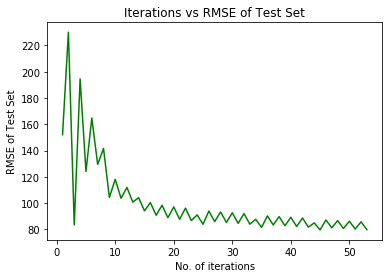

Initial Beta : 
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

Optimal Beta found : 
 [[-0.01788994]
 [ 0.0244415 ]
 [ 0.80562433]
 [ 0.07377758]
 [-0.04613424]
 [-0.00420336]
 [-0.13351567]
 [ 0.09828298]
 [-0.09278986]
 [ 0.25588079]
 [-0.00215409]]
No.of iterations:  31

Alpha :  0.00042968750000000006


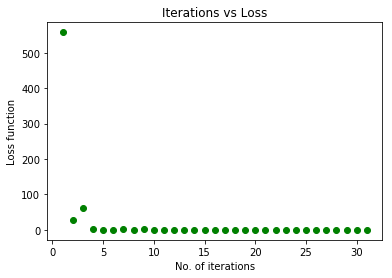

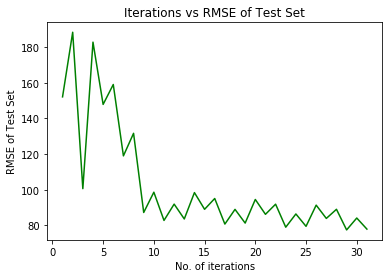

In [15]:
#Calling armijo step length function
gradientDescent_StepLength(xTrain,yTrain,xTest,yTest,"Armijo")

#Calling armijo step length function
gradientDescent_StepLength(xTrain,yTrain,xTest,yTest,"Bold driver")